# Overview
- nb010の改良
- tawaraさんの[ディスカッション](https://www.guruguru.science/competitions/13/discussions/cbb736e9-f0f7-4847-811e-fe038e8ed0e8/)を元に、RMSLEを最適化
- RMSLEをMSLEの問題としてといて、後処理でRMSLEに戻す方法

# Const

In [18]:
NB = '011'
N_SPLITS = 5
SHOW_LOG = True
VERBOSE = 10
# VERBOSE = None
EARLY_STOPPING_ROUNDS = 100


PATH_TRAIN = './../data/official/train.csv'
PATH_TEST = './../data/official/test.csv'
PATH_SAMPLE_SUBMITTION = './../data/official/atmaCup8_sample-submission.csv'
SAVE_DIR = f'../data/output_nb/nb{NB}/'

feat_train_only = ['JP_Sales', 'Global_Sales', 'NA_Sales', 'Other_Sales', 'EU_Sales']
feat_common = ['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher',
           'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer',
           'Rating']
feat_string = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
feat_num = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']

# Import everything I need :)

In [2]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# My function

In [37]:
def metric(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred) ** .5

def preprocess_User_Score(df):
    '''
    - tbdをnanにする
    - stringをfloatにする
    '''
    mask = df.User_Score.values == 'tbd'
    df.User_Score[mask] = np.nan
    df.User_Score = df.User_Score.values.astype(float)
    return df

def string_encode(df_trn, df_te, cols):
    '''
    - np.nanがあれば、'nan'に置き換える
    - label encodingする
    '''
    df = pd.concat([df_trn, df_te], axis=0).copy()
    df[cols] = df[cols].replace(np.nan, 'nan')
    df_trn[cols] = df_trn[cols].replace(np.nan, 'nan')
    df_te[cols] = df_te[cols].replace(np.nan, 'nan')
    for col in cols:
        le = LabelEncoder()
        le.fit(df[col])
        df_trn[col] = le.transform(df_trn[col])
        df_te[col] = le.transform(df_te[col])
    return df_trn, df_te

def df_preprocessing(df_trn, df_te, string_cols):
    df_trn = preprocess_User_Score(df_trn)
    df_te = preprocess_User_Score(df_te)
    df_trn, df_te = string_encode(df_trn, df_te, string_cols)
    return df_trn, df_te

In [4]:
def run_fold_lgbm(_X_trn, _y_trn, _X_val, _y_val, _X_te, model_config, show_log=True):
    FEAT_STRING = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
    
    # train
    model = LGBMRegressor(objective='regression', metric='rmse', **model_config)
    model.fit(_X_trn, _y_trn.values[:, 0],
              categorical_feature=FEAT_STRING,
              eval_set=[(_X_trn, _y_trn), (_X_val, _y_val)],
              verbose=VERBOSE,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS,
             )
    
    # predict
    y_trn_pred = model.predict(_X_trn)
    y_val_pred = model.predict(_X_val)
    _y_test_pred = model.predict(_X_te)
    
    # postprocessiing
    y_trn_pred[y_trn_pred <= 1] = 1
    y_val_pred[y_val_pred <= 1] = 1
    y_trn_pred = np.expm1(y_trn_pred)  # exp を適用して 1 を引く
    y_val_pred = np.expm1(y_val_pred)  # exp を適用して 1 を引く
    _y_test_pred = np.expm1(_y_test_pred)  # exp を適用して 1 を引く
    
    if show_log:
        print(show_log)
        print(f'score train: {metric(np.expm1(_y_trn), y_trn_pred):.5f}')
        print(f'score valid: {metric(np.expm1(_y_val), y_val_pred):.5f}')
        print('')
    
    return y_trn_pred, y_val_pred, _y_test_pred

def run(X, y, X_te, splitter, use_col, model_config, show_log=True):
    print(f'use_col: {use_col}\n') if show_log else None

    oof = np.zeros(len(X))
    y_test_pred = np.zeros(len(X_te))
    for fold_i, (idx_trn, idx_val) in enumerate(splitter.split(X)):
        if show_log:
            print(f'::Fold {fold_i+1}/{N_SPLITS} start at {time.ctime()}::')
        X_trn, X_val = X.iloc[idx_trn, :], X.iloc[idx_val, :]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        X_trn = pd.DataFrame(X_trn, columns=X.columns)
        X_val = pd.DataFrame(X_val, columns=X.columns)

        # train
        y_trn_pred, y_val_pred, _y_test_pred = run_fold_lgbm(X_trn, y_trn, X_val, y_val, 
                                                             X_te, model_config, show_log=show_log)

        # result
        oof[idx_val] = y_val_pred
        y_test_pred += _y_test_pred / N_SPLITS


    y_test_pred[y_test_pred <= 1] = 1
    return oof, y_test_pred

# Preparation

set

In [5]:
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

<br>

load dataset

In [6]:
train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)
ss = pd.read_csv(PATH_SAMPLE_SUBMITTION)

<br>

preprocess

In [7]:
train, test = df_preprocessing(train, test, feat_string)

In [8]:
mask = test.columns != 'Name'
use_col = test.columns[mask].tolist()
use_col

['Platform',
 'Year_of_Release',
 'Genre',
 'Publisher',
 'Critic_Score',
 'Critic_Count',
 'User_Score',
 'User_Count',
 'Developer',
 'Rating']

In [9]:
X = train[use_col].copy()
y = train[['Global_Sales']].copy()
X_te = test[use_col].copy()

In [10]:
X

,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,26,NaN,0,552,74.0,17.0,7.9,22.0,1511,2
1,26,NaN,0,290,78.0,22.0,6.6,28.0,1511,2
2,19,NaN,0,552,73.0,5.0,7.4,10.0,1511,2
3,0,NaN,0,53,NaN,NaN,NaN,NaN,1690,8
4,26,NaN,0,552,76.0,8.0,7.8,13.0,1511,2
...,...,...,...,...,...,...,...,...,...,...
8354,13,2016.0,11,392,78.0,57.0,8.0,569.0,1094,8
8355,13,2016.0,11,275,NaN,NaN,NaN,NaN,1690,8
8356,20,2017.0,0,233,NaN,NaN,NaN,NaN,1690,8
8357,18,2017.0,7,448,NaN,NaN,NaN,NaN,1690,8


In [11]:
# RMSLE を RMSEとしいて解く
y = np.log1p(y)  # 1 を足してlog を適用

# Create Model

In [12]:
splitter = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2020)

In [30]:
model_config = {
    'n_estimators': 800,
    'max_depth': 55,
    'subsample': 0.5,
    'colsample_bytree': 0.9, 
#     'learning_rate': 0.006437110612661787,
    'learning_rate': 0.02,
    'reg_alpha': 5.0,
    'reg_lambda': 5.0,
    'min_child_samples': 57
    }

In [38]:
%%time
oof, y_test_pred = run(X, y, X_te, splitter, use_col, model_config, show_log=SHOW_LOG)
print(f'oof score: {metric(np.expm1(y), oof):.5f}')

use_col: ['Platform', 'Year_of_Release', 'Genre', 'Publisher', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating']

::Fold 1/5 start at Sat Dec  5 14:07:40 2020::
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 1.28105	valid_1's rmse: 1.2689
[20]	valid_0's rmse: 1.1916	valid_1's rmse: 1.18533
[30]	valid_0's rmse: 1.12332	valid_1's rmse: 1.12147
[40]	valid_0's rmse: 1.07122	valid_1's rmse: 1.07304
[50]	valid_0's rmse: 1.02937	valid_1's rmse: 1.03461
[60]	valid_0's rmse: 0.996949	valid_1's rmse: 1.00581
[70]	valid_0's rmse: 0.970951	valid_1's rmse: 0.983776
[80]	valid_0's rmse: 0.949714	valid_1's rmse: 0.96501
[90]	valid_0's rmse: 0.932284	valid_1's rmse: 0.951002
[100]	valid_0's rmse: 0.917756	valid_1's rmse: 0.939471
[110]	valid_0's rmse: 0.904923	valid_1's rmse: 0.929801
[120]	valid_0's rmse: 0.893494	valid_1's rmse: 0.922205
[130]	valid_0's rmse: 0.883206	valid_1's rmse: 0.915194
[140]	valid_0's rmse: 0.873984	valid_1'

# create sub

In [15]:
ss['Global_Sales'] = y_test_pred
save_path = f'{SAVE_DIR}submission.csv'
ss.to_csv(save_path, index=False)

print(f'save: {save_path}')

save: ../data/output_nb/nb011/submission.csv


# Analysis

Text(0, 0.5, 'Pred')

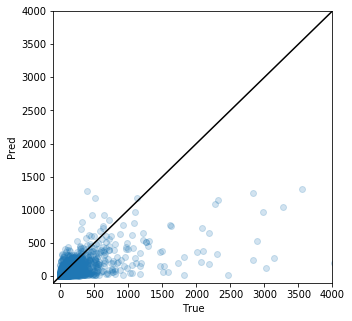

In [39]:
plt.figure(figsize=(5, 5))
plt.plot([-200, 8000], [-200, 8000], color='black')
plt.scatter(np.expm1(y), oof, alpha=0.2)
plt.xlim(-100, 4000)
plt.ylim(-100, 4000)
plt.xlabel('True')
plt.ylabel('Pred')

(-100, 1000)

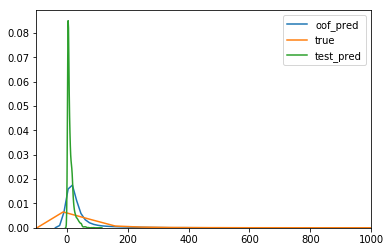

In [40]:
sns.kdeplot(oof, label='oof_pred')
sns.kdeplot(np.expm1(y.Global_Sales.values), label='true')
sns.kdeplot(y_test_pred, label='test_pred')
plt.xlim(-100, 1000)